In [ ]:
# Libraries
import time
from collections import deque, namedtuple # deque -> memory buffer, namedtuple -> store experience tuples

import gym
import pandas
import numpy as np
import tensorflow as tf
import utils
import PIL.Image
import seaborn as sns
import matplotlib.pyplot as plt 

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

### Environement State - Lunar Lander (OpenAI - gym)
In the lunar landing model, the environment state refers to the state of the lunar lander. Specifically, where it is positioned within the defined 2-D coordinate plane of the environment (x,y), the tilt of the lunar craft ($\theta$) the velocities of the lunar module decending (x',y', $\theta'$), and whether or not the lander has the left (L) or right (R) foot touching the surface.

This environment state will represent the input layer of the neural network noted by 1x8 state vector:
[x, y, $\theta$, x', y', $\theta'$, L, R]

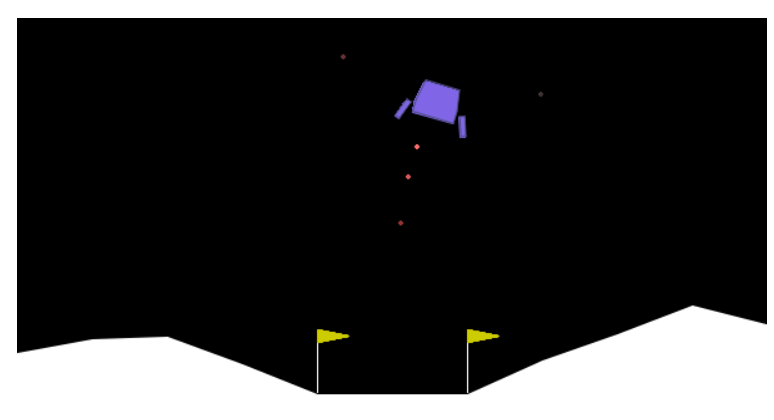

##### Action State
The action state represents the number and types of actions the lunar lander can perform in the environment. In the context of this environment, the lunar lander can perform the following actions denoted from action 1 - 4: 

1. Do nothing => 0
2. Fire Right Engine (Left) => 1
3. Fire Main Engine (Up-down) => 2
4. Fire Left Engine (Right) => 3



##### Rewards

In Reinforcement Learning, the objective is to learn a policy ($\pi$) that maximizes the expected return Q(s,a). The return can be defined by Bellman's equation and is a function of the expected rewards achieved at each step.

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$


In the case of the Lunar Lander, we want to incentivize the lander to develop a policy which does the following:
1. minimizes the amount of fuel that is used upon descent
2. land within the flags of the environment - the closer to the center coordinate (0,0) the better
3. minimize the amount of tilt the lander has upon descent
4. land the lander with both legs in contact with the ground
5. land safespectively

For each step, the reward is provided given the following guidelines:
1. is increased/decreased the closer/further the lander is to the landing pad.
2. is increased/decreased the slower/faster the lander is moving.
3. is decreased the more the lander is tilted (target angle is horizontal)
4. is increased by 10 points for each leg that is in contact with the ground.
5. is decreased by 0.03 points each frame a sides ine is firing.
6. is decreased by 0.3 points each frame the maiengine s firing.
7. The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively

##### Episode Termination
An episode ends (i.e the environment enters a terminal state) if:
1. The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).
2. The absolute value of the lander's $x$-coordinate is greater than 1 (i.e. it goes beyond the left or right border)

In [ ]:
# Environment Set Up
env = gym.make('LunarLander-v2')
env.reset()
PIL.Image.fromarray(env.render(mode = 'rgb_array'))

In [ ]:
# Define Input States and Action Options
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

#### DQN Architecture

Though the DQN shines mainly in a high dimensional space and action environment, in games such as Space invaders, this exercise will operate in the Lunar Lander environment (from openAI's gym) with a total of 4 actions and 8 sensory inputs.

- Input (x): State Vectors 8 inputs
- Output (y): max(Q(action states)) 4 outputs (number of action states)


The proposed architecture in the DQN paper is a Convolutional Neural Network (CNN) that develops an optimal policy taking a 210x160 color video at 60 Hz as an input, taking the input through 3 convolutional layers and 2 fully connected layers to output a vector of actions (size 1x18) to determine the action (of the joystick).

In the case of the Lunar Lander, the proposed architecture by the instructor is simpler because of the lower dimensionality of the environment space and actions. As noted above the input will be the positioning or state of the lunar lander, rather than video (high sensory input).


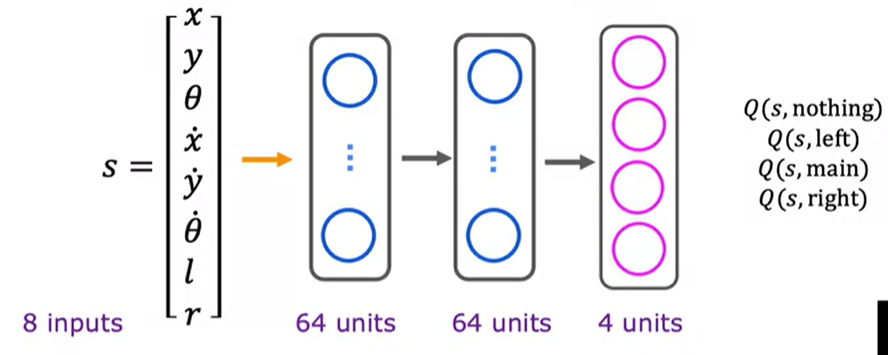

In [ ]:
#Hyperparameters 
MEMORY_SIZE = 10000       # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [ ]:
# Define the NN architecture for Q_target and Q

q_network = Sequential([
    Input(shape = state_size),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = num_actions, activation = 'linear')
])

# # Batch Normalization version ### 
# q_network = Sequential([
#     Input(shape = state_size),
#     BatchNormalization(axis =1),
#     Dense(units = 64, activation = 'relu'),
#     BatchNormalization(axis =1),
#     Dense(units = 64, activation = 'relu'),
#     Dense(units = num_actions, activation = 'linear')
# ])

q_target_network = Sequential([
    Input(shape = state_size),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = num_actions, activation = 'linear')
])

# # Batch Normalization version ### 
# q_target_network = Sequential([
#     Input(shape = state_size),
#     BatchNormalization(axis =1),
#     Dense(units = 64, activation = 'relu'),
#     BatchNormalization(axis =1),
#     Dense(units = 64, activation = 'relu'),
#     Dense(units = num_actions, activation = 'linear')
# ])

optimizer = Adam(learning_rate = ALPHA)

# for i in range(len(q_network.get_weights())):
#     print(q_network.get_weights()[i].shape)

print(type(q_network))
# print(q_network.trainable_variables)

### Experiences - Training Set

The experiences refer to the namedtuple type of datastructure that stores information required for a training data instance. Each training example will be stored in the memory buffer to then access during the time of training. 

$$Experiences(S,A,R(s),S',D)$$



In [ ]:
# Define the experiences data structure (named tuple) - for the training set 
Experience = namedtuple('Experience', field_names = ['state', 'action', 'reward', 'next_state', 'done'])

### Target Q Network Implementation
This technique is employed to ensure that the change in the target y is gradual.

There are 2 DQN's defined in the previous section of the lab: 
1. $Q_{Network}$ - represents the DQN that will run gradient descent on the mini batched samples to learn w,b
2. $Q_{Target Network}$ - represents the DQN that will have weights updated from Q_Network using soft update 


##### Compute Loss Function
We are computing the loss between the output of the Bellman Equation, using $Q_{target network}$ to output $Q_{next state}$, and the estimated q_value $Q_{current state}$. These should be the same value if Bellman Equation were to be true. Therefore by minimizing the loss - or converging the difference to 0, we are inherently training the Q_network to be closer to optimal. During the calculation of the loss - be sure to note that it is the q_values for the target that will constantly be updating whereas the Q_network will only be updating at every step C using soft update. 


$$\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}} $$


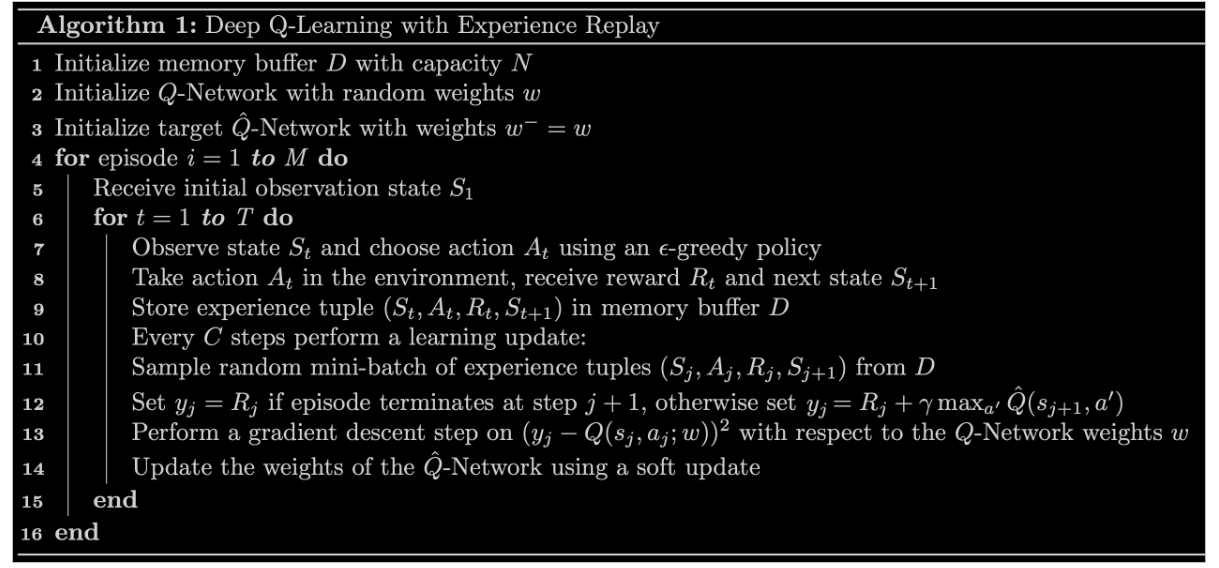

In [ ]:
# Define Loss Function - using Mean Squared
def compute_loss(experiences, gamma, q_target, q_network):
    # experiences - (named tuple - 5 fields) -  ['current_state', 'current_action', 'reward', 'next_state', 'terminal']
    # gamma - (float) defined in hyperparameter
    # q_target - ('keras.src.models.sequential.Sequential) 
    # q_network - ('keras.src.models.sequential.Sequential) 

    
    # unpack experiences
    state, action, reward, next_state, done = experiences

    #Extract max Q(s,a) from Q_target
    q_max_sa = tf.reduce_max(q_target(next_state), axis = 1)
    
    # Calculate y_Target using variables 
    y_target = reward + (1-done)*(gamma*q_max_sa)

    # Extract Q_Values and reshape to shape of y_target
    q_values = q_network(state)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(action, tf.int32)], axis=1))

    # Calculate MSE between q_target and q_network 
    loss = MSE(y_target, q_values)

    return loss

### Tensorflow Relevant Functions Docs 
- ###### @tf function
    - decorator is used to convert a python function into a TensorFlow graph - allowing for the function to be executed much more efficiently. 
- ###### tf.GradientTape() as tape
    - a context manager that records operations for automatic differentiation - by recording the operations executed within the context, it allows you to compute gradients with respect to the recorded operations 
- ###### tape.gradient('target', 'sources', 'output_gradients')
    - 'target' - tensor to be differentied
    - 'sources' - the list or structure of tensors with respect to which the gradient is computed
    - computes the gradient of a target tensor (often a loss) with respect to some source tensors
- ###### optimizer.apply_gradients(zip('grads_and_vars'))
    - applies the computed gradients to the variable to minimize the loss
    - 'grads_and_vars' - a list of (gradient, variable) pairs
- ###### zip()
    - built in Python function - aggregates elements from two or more iterables and returns an iterator or tuple
    - per the documentation for applying gradients - the input must be in the form of a pair

In [ ]:
@tf.function
def agent_learn(experiences, gamma): 
    # use the training set (experiences) to define Qnew and use soft update to update the current weights and biases of Q
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma,q_target_network,q_network,)

    gradients = tape.gradient(loss, q_network.trainable_variables)

    #update weights of the network using Adam's optimizer 
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    #update the weights of the target q_network -> using soft update
    utils.update_target_network(q_network, q_target_network)
    print(q_network)

In [ ]:
# Define Memory Buffer Size and Initialize
memory_buffer = deque(maxlen = MEMORY_SIZE)

In [ ]:
# Initialize target Q-Network with weights w^- = w 
q_target_network.set_weights(q_network.get_weights())

### Utility Functions
- ###### get_action(q_values, epsilon)
    - q_values: (arr)
    - epsilon: (float)
    - will return an action [0,1,2,3,4] based on the max q_value OR by "exploration"
    - if epsilon is < than a random number chosen by the random.random() function, then it wil choose the max q_value
- ###### check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
    - t: (float) time step
    - NUM_STEPS_FOR_UPDATE: (float) how often the update will occur
    - memory_buffer: (deque)
    - return True if the time step (t) is a multiple of NUM_STEPS_FOR_UPDATE AND if the size of the memory buffer is > Minibatch size (64)
- ###### get_experiences(memory_buffer)
    - memory_buffer: (deque)
    - mini-batch experiences from the memory_buffer - randomly selecting 64 experiences to feed into the model as an input
    - converts all experience fields into a tensor and returns a tuple of tensor type inputs
- ###### get_new_eps(epsilon)
    - epsilon: (float)
    - this will define a new epsilon based on the decay rate defined in the utils.py script
    - as the model continues to learn the epsilon will define how much exploration is being done
    - as the model gets more experience - the epsilon should approach the MIN value (.01)
 
- ###### update_target_network(q_network, target_q_network)
    - q_network: (Tensorflow.Sequential) 
    - target_q_network:(Tensorflow.Sequential)
    - update the weights of target_q_network based on soft update
$$
\theta^- = \tau \theta + (1 -\tau) \theta^- 
$$


In [ ]:
def execute_learning(epsilon, num_episodes, num_p_av,max_num_timesteps):

    # Execute Learning Algorithm
    total_point_history = []
    total_action_history = []
    episodes_to_comp = 0
    # target_num_episodes = 500
    start = time.time()
    
    for i in range(num_episodes):
        # recieve initial observation state S1 from environment
        state = env.reset()
        total_points = 0
        for t in range(max_num_timesteps):
            # choose action At using e-greedy policy
            # use the current state as an input to determine what action
            # State => (8,1) matrix input
            state_qn = np.expand_dims(state, axis= 0)
            q_values = q_network(state_qn)
            # take action in environment, receive reward R(t) and next state St+1
            action = utils.get_action(q_values, epsilon)
            next_state, reward, done, _ = env.step(action)
    
            #Store Tuple into the memory buffer
            memory_buffer.append(Experience(state, action, reward, next_state, done))
    
            # Update Check: t steps > NUM_STEPS_FOR_UPDATE
            update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
    
            # update -> run learning algorithm
            if update: 
                # sample mini-batch of samples from the memory buffer
                experiences = utils.get_experiences(memory_buffer)
                agent_learn(experiences, GAMMA)
    
            # move env to next state
            state = next_state.copy()
            total_points += reward
    
            #break if terminal
            if done:
                break
        
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])
        # calculate new eps for greedy alg
        # use the number of episodes (normalized) to input into a sigmoid function
        norm_episodes = i / num_episodes
        epsilon = utils.get_new_eps(epsilon, norm_episodes)
    
        # scoring tracker
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
        
        if (i+1) % num_p_av == 0:
                print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        
        # We will consider that the environment is solved if we get an
        # average of 200 points in the last 100 episodes.
        if av_latest_points >= 200.0:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            q_network.save('lunar_lander_model.h5')
            break
        episodes_to_comp+=1
                
    tot_time = time.time() - start
    
    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

    return (total_point_history,i)

### $\epsilon$- Greedy Policy

Due to the random initialization of NN weights, ($w$) in this case, there may be instances where the model will be susceptible to certain biases and preconceptions that may prevent the target goal. The same way a human might not act in a way that seems foreign, the model faces the same challenges and may become stuck as a result. To address this obstacle in developing a stable reinforcement model, the the $\epsilon$ greedy policy is used as a method to allow the model to explore actions that it would normally not choose. The policy achieves this by varying variable $\epsilon$ from 1.0 -> 0.1 to ensure that the model is exploring different actions earlier on in the learning cycle and relying on the optimal action (defined by the Q approximater) later on in the learning cycle. 

**Exploration**: Action chosen at random 

**Exploitation (Greedy)**: action that maximizes return $Q(s,a)$

The implementation preferred by the Coursera instructors, defines an epsilon decay function of .995, which is multiplied by $\epsilon$ after each episode to control the amount of exploration the model does. The epsilon profile is shown in the graph below: 

**Coursera Lab Specified Profile - Decay Factor: .995:**

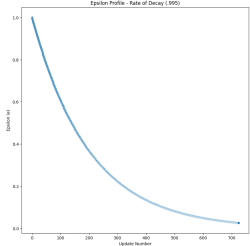 


In [ ]:
# Define Learning Parameters
epsilon = 1.0
num_episodes = 2000
num_p_av = 100 # number of total points to use for averaging
max_num_timesteps = 1000 

In [ ]:
# Run the learning protocol for 100 times for each configuration to confirm the validity of model imporvement
df = pandas.DataFrame(columns = ["EPOCH", "Total Point Average", "Epsilon"])
# Experiment NUM
k = 1

total_point, episodes = execute_learning(epsilon, num_episodes, num_p_av,max_num_timesteps)
# concatinate dataframe to include this information
epoch_arr = np.ones(len(total_point), dtype = int)*k
eps_arr = utils.plot_epsilon()
# print(len(total_point), len(eps_arr), len(range(num_episodes-1)))
temp_dict = {"EPOCH": epoch_arr, "Total Point Average":total_point, "Epsilon":eps_arr}
temp_df = pandas.DataFrame.from_dict(temp_dict)
df = pandas.concat([df,temp_df], ignore_index = True)

In [ ]:
# Plot epsilon trend across the training episodes
eps_arr = utils.plot_epsilon()
fig, ax = plt.subplots(figsize = (10,10))
# print(eps_arr)
sns.scatterplot(x = range(len(eps_arr)), y = eps_arr, ax = ax)
plt.title("Epsilon Profile - Rate of Decay (Sigmoid)")
ax.set(xlabel = 'Update Number', ylabel = 'Epsilon (e)')

In [ ]:
# Plot the total point history along with the moving average
FILENAME = 'EPS_LIN_10_sample_data.csv'
utils.plot_history(df['Total Point Average'])
# df.to_csv(FILENAME, mode = 'a', header = False)

### Exploration Results


#### Epsilon Profile Modification
As an extension of the lab, I wanted to explore the impact of changing the epsilon profile on the stability and solving time of the model. The baseline profile shown in the previous section is an exponential decay profile where epsilon is high (more exploration) at the start but immediately decreases towards the epsilon lower limit. In this exploration I want to explore the performance of two different epsilon profiles: linear and sigmoid. Though I am not familiar with epsilon tuning methologies, I want to check the following intuitions: 
1. If the model favor exploration for longer at the start of the learning process, does it successfully solve the environment quicker when epsilon is small (ecploiting)?
2. If the model has more of a gradual linear decay (as opposed to exponential) is there more noise in the total point averages due to the ongoing exploration of the model?

**Benchmark Profile (Exponential Decay)**

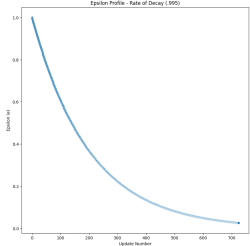

**Explored Profile (Linear):**

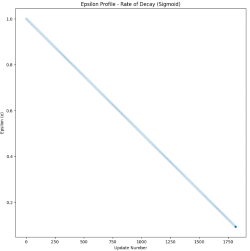

**Explored Profile (Sigmoid):**

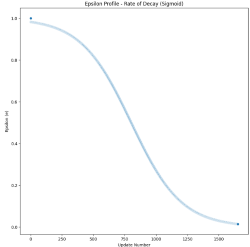


##### **Results**
The benchmark profile (exponential decay) outperformed the two proposed alternative profiles (sigmoid and linear) and was able to solve the environment in **724 episodes** as opposed to the **sigmoid's: 1652 episodes**, and the **linear's: 1815 episodes** . When visually looking at the Sigmoid plot, it appears that the slope of the rolling total point averages appears to be smaller (indicating a flatter trajectory) when compared to the benchmark epsilon profile. Even when the sigmoid curve approached the minimum epsilon value, there was no obvious change in slope, indicating that the model benefitied from the additional exploration time during the start of training (this of course needs to be proven across a myraid of models to generalize). This provides an answer to intuition #1. In terms of analyzing the performance of the linear epsilon profile, it was expected to underperform the other profiles, which we see confirmed based on the comparison plot below. The question of comparing noise is something I need to further read about - however, visually it does seem that the exploration done later in the training process does not lead to further noise (visually oscillation of the rolling total point average) when compared to the other two scenarios.

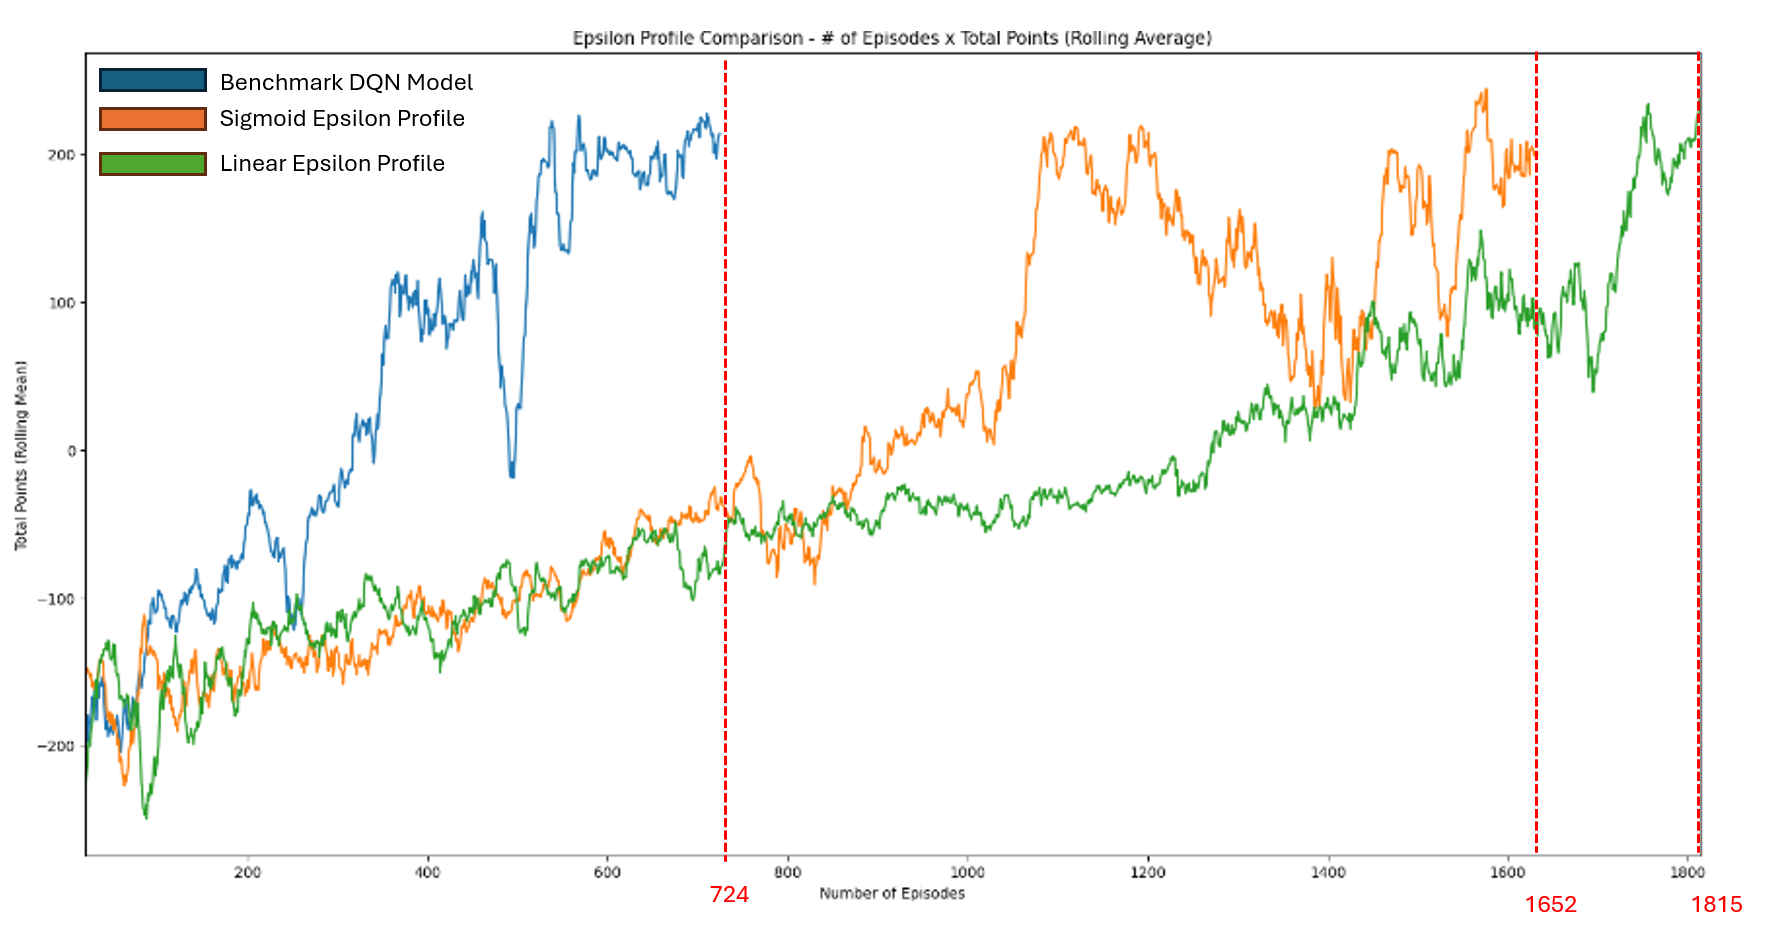


##### **Batch Normalization (Iofee & Szegedy, 2015)**
Ioffe and Szegedy proposed Batch Normalization as a solution to simplify the training of Deep Neural Networks by incorporating a normalization layer within the neural network architecture to address the covariate shift issue as described in (Shimodaira, 2000). Internal covariate shift occurs when the inputs of each layer of the NN change during training therefore forcing the layers to continuously adapt to the new distribution. When applied to an image classification model, the implementation of Batch Normalization achieved the same accuracy as a benchmark with 14 times fewer steps. For this lab, I will implement Batch Normalization layers in between each of the 2  'ReLu' activation layers to improve the efficiency of the model.


##### **Results**
Implementation of the Batch Normalization layers **yielded a 13.5% (626 episodes vs 724 episodes for the benchmark) decrease** in the number of episodes needed to solve the Lunar Lander environment. 

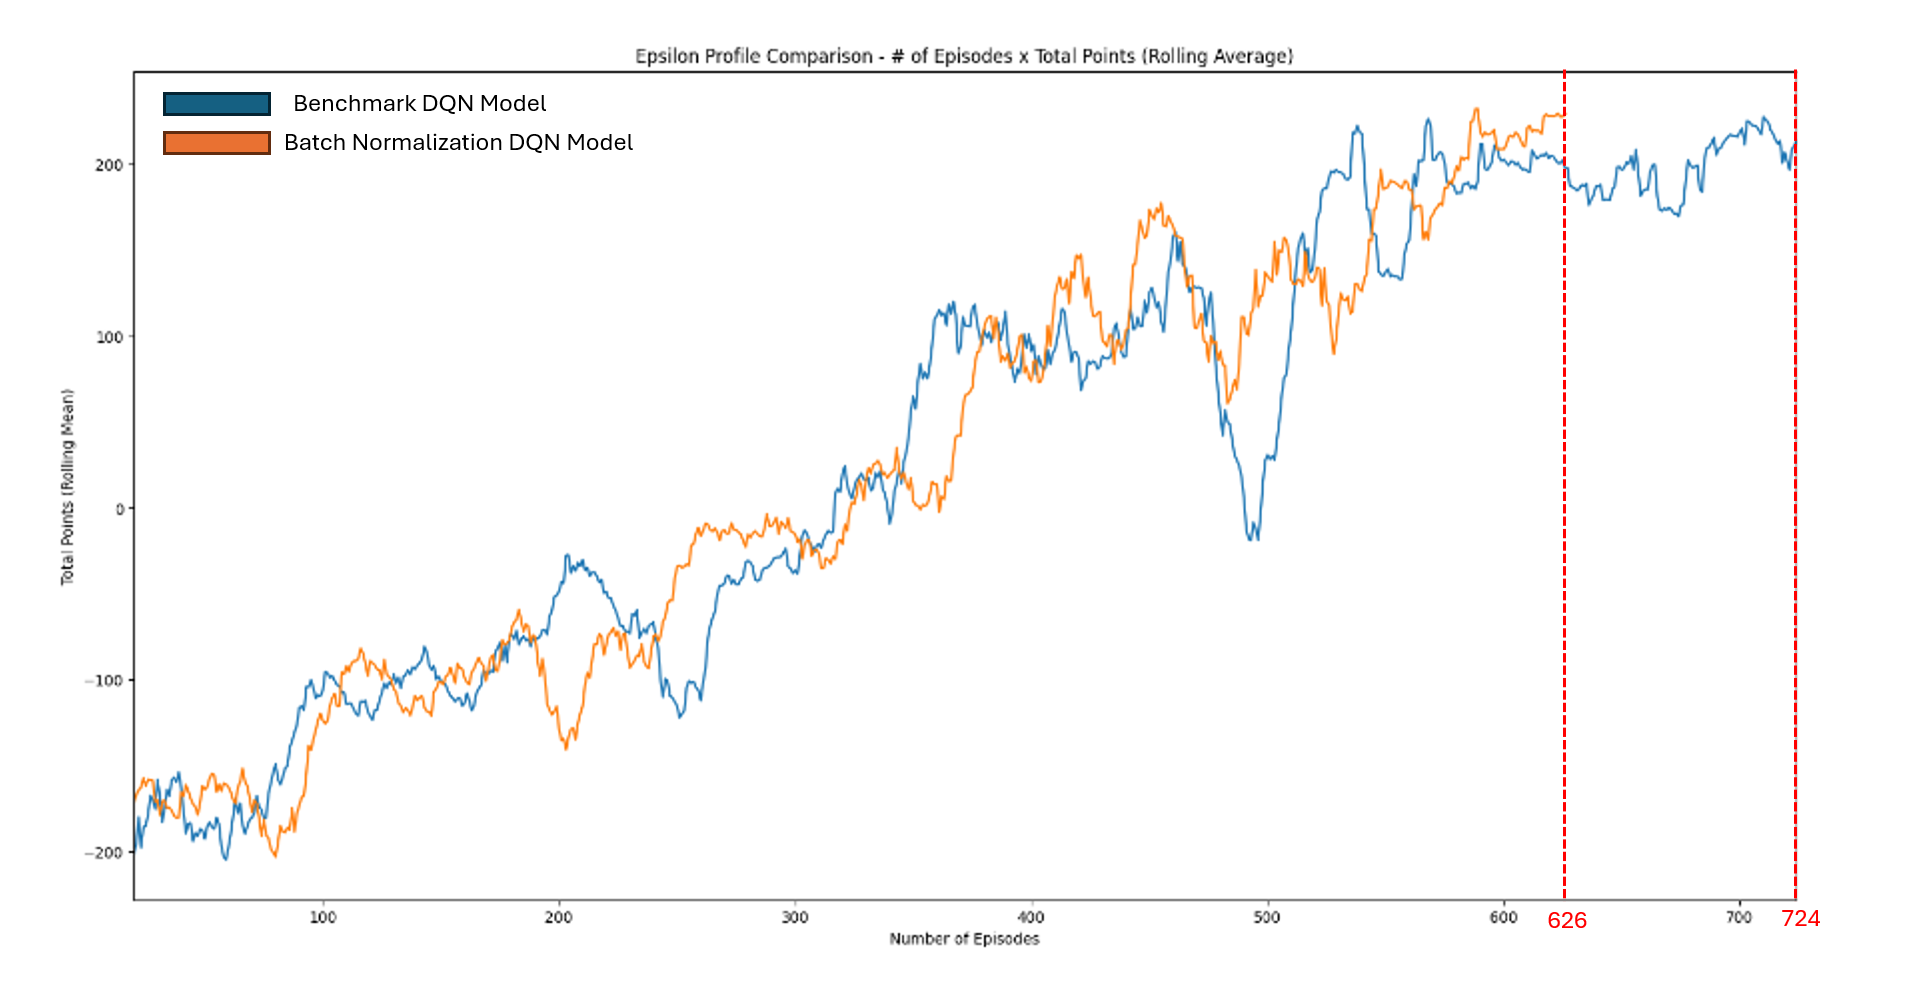


### Appendix - 

#### Benchmark Performance Metrics
- Avg Episodes to solve Environment: 724 episodes
- Observations:
    - surprised that the number of episodes required to solve the environment did not change after restarting the kernal and reinitializing the NN
    - see a large V shape drop in total history point rolling average towards the later part of the training 

Hyperparameters: 
- Minibatch size: 64
- Tau: .001
- Decay Coefficient for $\epsilon$: .995
- Min $\epsilon$: .01  

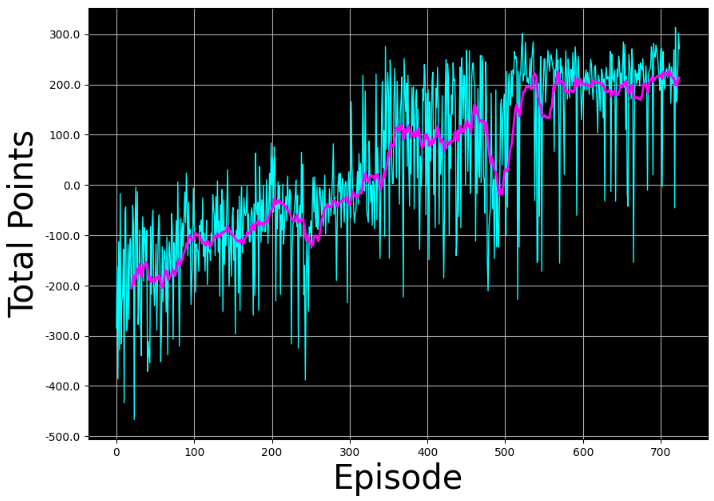


#### Epsilon Sigmoid Profile Performance Metrics
- Avg Episodes to solve Environment: 1652
- Observations:
    - took almost twice as many episodes to converge relative to the benchmark
    - this profile does not appear to be conducive to efficient solving of the envionrment Q function

Hyperparameters: 
- Minibatch size: 64
- Tau: .001
- Decay Rate for $\epsilon$: $1 / 1 + e^{-10x+6}$
    - *where x is the 1- (episode number / total number of episodes)*
- Min $\epsilon$: .01  


#### Linear Epsilon Profile Evaluation
- Avg Episodes to solve Environment: 1815

Hyperparameters: 
- Minibatch size: 64
- Tau: .001
- Decay Rate for $\epsilon$: x
    - *where x is the 1- (episode number / total number of episodes)*
- Min $\epsilon$: .01  

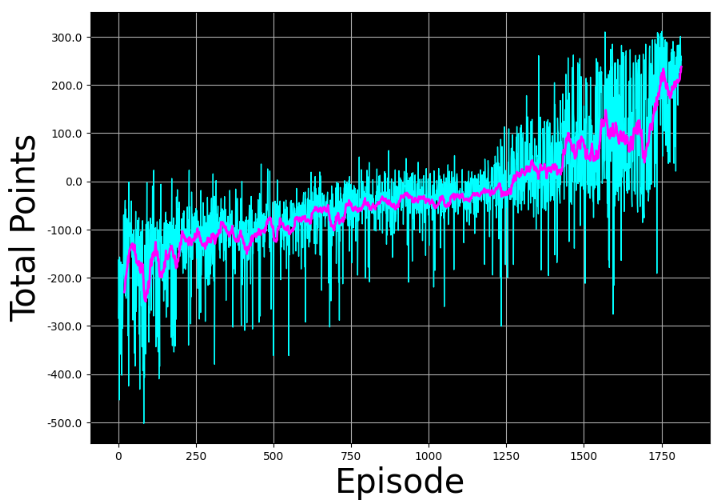

#### Batch Normalization Performance Metrics - 10 sample averages
- Avg Episodes to solve Environment: 626
- Observations:

Hyperparameters: 
- Minibatch size: 64
- Tau: .001
- Decay Coefficient for $\epsilon$: .995
- Min $\epsilon$: .01  

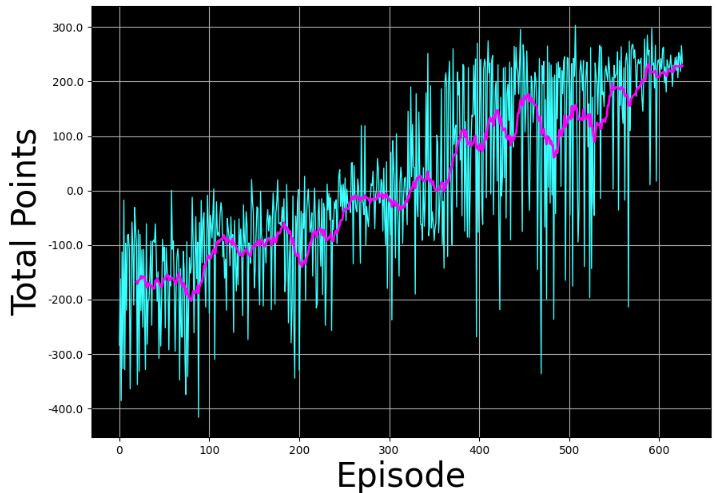

